# **Topic 2. Market Basket Analysis using the FPGrowth algorithm
# **
**Objective**: aimed at identifying frequent itemsets and association rules from a given dataset of transactions.

The primary objective was to uncover patterns and insights that could be used for strategic business decisions, such as product placement, bundling, and recommendations.

 
**Dataset**: Groceries-Dataset

The dataset has 38765 rows of the purchase orders of people from the grocery stores. 

Workflow 

1, Data Preprocessing: Group products by transactions (transaction ID).

2, Apply FPGrowth: Using Spark MLlib, I applied the FPGrowth algorithm to identify frequent itemsets. Generate frequent itemsets and association rules.

Parameters such as minSupport and minConfidence were tuned for optimal results:
- minSupport: Ensures the algorithm focuses on itemsets that appear frequently in transactions.
- minConfidence: Filters association rules based on their predictive strength.

3, Visualization and Analysis:
- Generated visualizations, such as bar charts and pie charts, to display frequent itemsets and association rules.
- Insights were drawn to highlight popular combinations of items and their potential utility in marketing or sales strategies.

4, Analyzing and visualizing association rules related to a specific item, "whole milk" to refine the rules to focus on the most impactful associations.

4, Frequent itemsets and high-confidence rules were reviewed.
Filtered rules with thresholds for confidence and lift, ensuring relevance for business applications.

In [0]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, collect_set
from pyspark.ml.fpm import FPGrowth

# Initialize Spark Session
spark = SparkSession.builder.appName("MarketBasketAnalysis").getOrCreate()

# Load the dataset
file_path = "/FileStore/tables/Groceries_dataset.csv"  # Path to the uploaded dataset
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Display the first few rows of the dataset
df.show(5)

# Check the schema to ensure data is loaded correctly
df.printSchema()


+-------------+----------+----------------+
|Member_number|      Date| itemDescription|
+-------------+----------+----------------+
|         1808|2015-07-21|  tropical fruit|
|         2552|2015-01-05|      whole milk|
|         2300|2015-09-19|       pip fruit|
|         1187|2015-12-12|other vegetables|
|         3037|2015-02-01|      whole milk|
+-------------+----------+----------------+
only showing top 5 rows

root
 |-- Member_number: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- itemDescription: string (nullable = true)



1, groupBy: Groups rows by Member_number (transaction ID).
collect_set: Aggregates itemDescription into a set to remove duplicates in each transaction.

2, Apply FPGrowth Algorithm

+ minSupport: Minimum support threshold for frequent itemsets (adjust based on dataset size).
For example, with 38,765 transactions, an itemset needs to appear in at least 775 transactions (38,765 * 0.02 = 775) to be considered frequent and included in the results.

+ minConfidence: Minimum confidence threshold for association rules.
With minConfidence = 0.3, the rules only be retained if the confidence of the rule is at least 30%.
This means that for a rule like A → B, at least 30% of transactions that contain A must also contain B for the rule to be considered valid.

+ Model Parameters: Tune minSupport and minConfidence based on the dataset characteristics to get meaningful patterns.

+ Start with minSupport=0.02 and minConfidence=0.3, then fine-tune based on the size and purpose of the dataset.

+ Combine these metrics with lift for more robust rule selection.


In [0]:
##Apply FPGrowth
# Step 1: Group data by 'Member_number' and aggregate items as a list
processed_df = df.groupBy("Member_number").agg(collect_set("itemDescription").alias("items"))

# Step 2: Configure and run the FPGrowth algorithm
fp_growth = FPGrowth(itemsCol="items", minSupport=0.02, minConfidence=0.3)
model = fp_growth.fit(processed_df)

# Step 3: Display sorted frequent itemsets
frequent_itemsets = model.freqItemsets
frequent_itemsets.orderBy(col("freq").desc()).show(truncate=False)  # Sorting by frequency

# Step 4: Display association rules, sorted by confidence
association_rules = model.associationRules
association_rules.orderBy(col("confidence").desc(), col("lift").desc()).show(truncate=False)  # Sorting by confidence and lift

# Step 5: Transform the input DataFrame (Optional)
transformed = model.transform(processed_df)
transformed.show(5, truncate=False)


+------------------------------+----+
|items                         |freq|
+------------------------------+----+
|[whole milk]                  |1786|
|[other vegetables]            |1468|
|[rolls/buns]                  |1363|
|[soda]                        |1222|
|[yogurt]                      |1103|
|[tropical fruit]              |911 |
|[root vegetables]             |899 |
|[bottled water]               |833 |
|[sausage]                     |803 |
|[other vegetables, whole milk]|746 |
|[citrus fruit]                |723 |
|[rolls/buns, whole milk]      |696 |
|[pastry]                      |692 |
|[pip fruit]                   |665 |
|[shopping bags]               |656 |
|[canned beer]                 |644 |
|[bottled beer]                |619 |
|[whipped/sour cream]          |603 |
|[soda, whole milk]            |589 |
|[yogurt, whole milk]          |587 |
+------------------------------+----+
only showing top 20 rows

+---------------------------------------------+------------+--

Visualise top 10 frequent itemsets and top 10 rules by lift

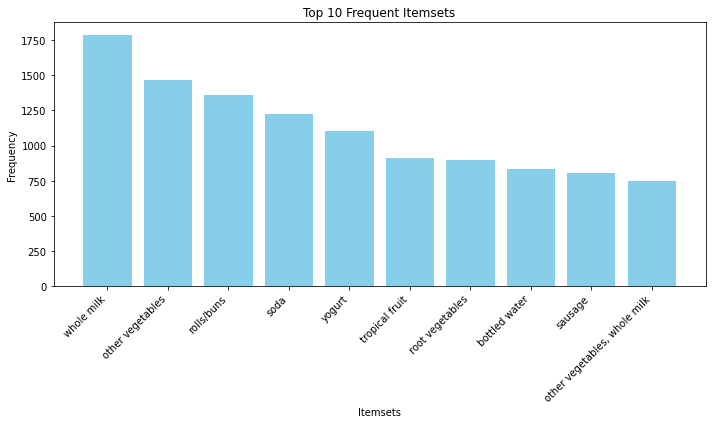

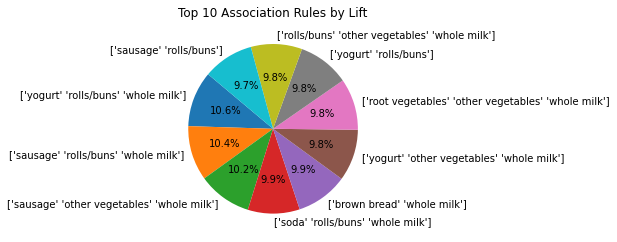

In [0]:
##Visualise frequent itemsets and association rules.

# Convert Spark DataFrames to Pandas for visualization
frequent_itemsets_pd = frequent_itemsets.toPandas()
association_rules_pd = association_rules.toPandas()

# Check the structure of 'items' column and convert itemsets to string for better visualization
frequent_itemsets_pd['items_str'] = frequent_itemsets_pd['items'].apply(lambda x: ', '.join(x))

# Visualize top 10 frequent itemsets by frequency
import matplotlib.pyplot as plt

# Sort by frequency and select top 10
top_10_itemsets = frequent_itemsets_pd.sort_values("freq", ascending=False).head(10)

# Plot top 10 frequent itemsets
plt.figure(figsize=(10, 6))
plt.bar(top_10_itemsets['items_str'], top_10_itemsets['freq'], color='skyblue')
plt.title("Top 10 Frequent Itemsets")
plt.xlabel("Itemsets")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()  
plt.show()

# Convert antecedent (list) to string for pie chart labels
association_rules_pd["antecedent_str"] = association_rules_pd["antecedent"].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))

# Get top 10 rules by lift
top_lift_rules = association_rules_pd.sort_values("lift", ascending=False).head(10)

# Create pie chart for top 10 rules by lift
plt.figure(figsize=(8, 8))
plt.pie(
    top_lift_rules["lift"],  # Numerical values
    labels=top_lift_rules["antecedent_str"],  # String labels
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Top 10 Association Rules by Lift")
plt.tight_layout()  # Adjust layout for better visualization
plt.show()



### Analyzing and visualizing association rules related to a specific item, "whole milk"
### 
High confidence (closer to 1) means that when antecedent is present, consequent is highly likely to also occur.

Low confidence indicates a weaker or less reliable relationship.

Confidence and Lift Affect Rule Quantity:

+ Confidence ensures rules are reliable.
+ Lift ensures rules have meaningful relationships.
With confidence > 0.7 and lift > 1.5, no rules were found.
With confidence > 0.5 and lift > 1.5, only one rule was identified, where the consequent is rolls/buns. Meaning there is a strong positive correlation between the antecedent (whatever triggers this rule) and rolls/buns compared to random chance.

**_Conclusion_**:
+ "Whole milk" is not a strong antecedent in this dataset. It might appear more frequently as a consequent.
Be purchased independently without strong associations. This makes it a "baseline" item that customers often add to their baskets.
+ Cross-Selling Potential:
Lowering the thresholds revealed weaker relationships. Recommend rolls/buns to customers purchasing whole milk.
Place rolls/buns strategically near these Milk Shelf in-store to increase cross-selling opportunities.

+--------------------+------------------+-------------------+------------------+
|          antecedent|        consequent|         confidence|              lift|
+--------------------+------------------+-------------------+------------------+
|[soda, other vege...|          [yogurt]|0.40370370370370373| 1.426688156878547|
|[soda, other vege...|   [bottled water]|0.31851851851851853|1.4904984215908585|
|[soda, other vege...|      [rolls/buns]|0.45925925925925926|1.3134208309556807|
|[sausage, soda, w...|      [rolls/buns]| 0.5256410256410257| 1.503263916323344|
|[bottled beer, wh...|      [rolls/buns]|0.44744744744744747|1.2796406090610053|
|[bottled beer, wh...|          [yogurt]| 0.3213213213213213|1.1355489669179606|
|[bottled beer, wh...|[other vegetables]|0.45345345345345345| 1.204061009238121|
|[bottled beer, wh...|            [soda]|0.33633633633633636|1.0728633707357114|
|[coffee, whole milk]|      [rolls/buns]| 0.3953488372093023|1.1306454640072343|
|[coffee, whole milk]|      

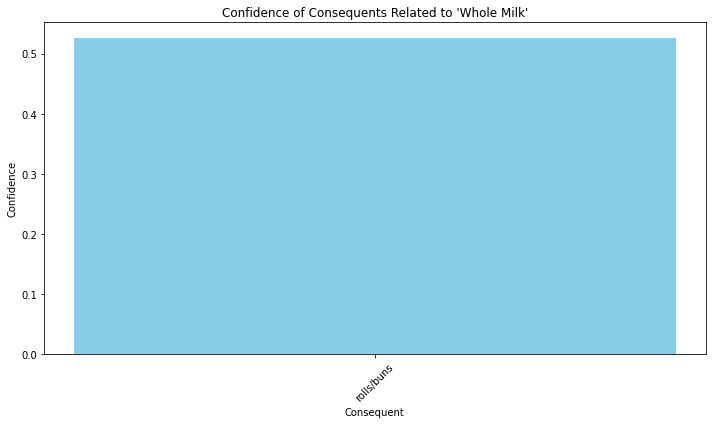

In [0]:
from pyspark.sql.functions import array_contains, col
import matplotlib.pyplot as plt

# Step 1: Filter association rules where the antecedent contains "whole milk"
milk_rules = association_rules.filter(array_contains(col("antecedent"), "whole milk"))

# Step 2: Select relevant columns and display the filtered rules
milk_rules.select("antecedent", "consequent", "confidence", "lift").show()

# Step 3: Convert the filtered rules to Pandas for easier manipulation
milk_rules_pd = milk_rules.toPandas()

# Step 4: Generate human-readable descriptions for each rule
for index, row in milk_rules_pd.iterrows():
    antecedent = ", ".join(row["antecedent"])
    consequent = ", ".join(row["consequent"])
    confidence = row["confidence"]
    lift = row["lift"]
    print(f"If a transaction contains [{antecedent}], it is likely to also contain [{consequent}] "
          f"with a confidence of {confidence:.2f} and a lift of {lift:.2f}.")

# Step 5: Further filter rules by confidence and lift thresholds
filtered_milk_rules = milk_rules.filter((col("confidence") > 0.5) & (col("lift") > 1.5))

# Step 6: Display the filtered rules
filtered_milk_rules.select("antecedent", "consequent", "confidence", "lift").show()

# Step 7: Convert the filtered rules to Pandas for visualization
filtered_milk_rules_pd = filtered_milk_rules.toPandas()

# Step 8: Visualize the confidence of consequents related to "whole milk"
plt.figure(figsize=(10, 6))
plt.bar(
    filtered_milk_rules_pd["consequent"].apply(lambda x: ', '.join(x)),  # Convert lists to strings
    filtered_milk_rules_pd["confidence"],
    color="skyblue"
)
plt.title("Confidence of Consequents Related to 'Whole Milk'")
plt.xlabel("Consequent")
plt.ylabel("Confidence")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### **Filtering association rules based on multiple metrics (confidence and lift) and then visualizing the results

1, Strong Associations Found: Rules with whole milk as the consequent show strong confidence and meaningful relationships (lift > 1).
Example: Products like yogurt, rolls/buns, bottled water, and curd are commonly associated with whole milk.

2, Low Prevalence of Rules: High support thresholds (support > 0.3) eliminate most rules, indicating no rule applies to a large portion of transactions.

3, Opportunities for Action:

+ Focus on promoting products associated with whole milk, such as yogurt, rolls/buns, and bottled water.

+ Lower thresholds for support to identify more actionable rules for niche products.

4, Recommendations:

+ Use lower support thresholds (e.g., support > 0.1) to identify additional rules for targeted marketing strategies.

+ Focus on rules with high lift and confidence for personalized recommendations or cross-selling.

In [0]:
from pyspark.sql.functions import col

# Filter rules based on metrics: Confidence > 0.6 and Lift > 1
high_quality_rules = association_rules.filter((col("confidence") > 0.6) & (col("lift") > 1))

# Display the filtered rules
high_quality_rules.select("antecedent", "consequent", "confidence", "lift").show()

# Filtering based on Support: Support > 0.3
high_support_rules = association_rules.filter(col("support") > 0.3)
high_support_rules.select("antecedent", "consequent", "support").show()

# Combine multiple metrics: Confidence > 0.6, Lift > 1.2, and Support > 0.2
custom_filtered_rules = association_rules.filter(
    (col("confidence") > 0.6) & (col("lift") > 1.2) & (col("support") > 0.2)
)

# Display combined filter results
custom_filtered_rules.select("antecedent", "consequent", "support", "confidence", "lift").show()


+--------------------+------------+------------------+------------------+
|          antecedent|  consequent|        confidence|              lift|
+--------------------+------------+------------------+------------------+
|[yogurt, rolls/bu...|[whole milk]|0.6568627450980392|1.4336231693125179|
|[beef, other vege...|[whole milk]| 0.601010101010101|1.3117230536043525|
|[bottled water, s...|[whole milk]|0.6013986013986014|1.3125709676661523|
|[bottled beer, pa...|[whole milk]|0.6030534351145038|1.3161826932118341|
|[bottled water, r...|[whole milk]|0.6293706293706294| 1.373620780115741|
|[brown bread, bot...|[whole milk]|0.6148648648648649|1.3419615023758362|
|[yogurt, soda, ot...|[whole milk]|0.6488095238095238|1.4160467658507971|
|      [beef, yogurt]|[whole milk]|0.6133333333333333|1.3386188876446434|
|[shopping bags, r...|[whole milk]|0.6162162162162163|1.3449108683151236|
|[frozen vegetable...|[whole milk]|           0.60625|1.3231592945128778|
|[beef, root veget...|[whole milk]|0.6


### Sorting and ranking association rules based on important metrics such as confidence and lift. 

**_Purpose_**: identifying the most valuable rules in the project

+ Sorting Rules: The association rules are sorted based on confidence (descending) and then lift (descending) to prioritize the most reliable and meaningful rules.

+ Viewing Top Rules: Displayed the top 10 rules to identify the strongest associations in terms of reliability (confidence) and meaningfulness (lift).

+ Creating an Importance Metric: Added a new column importance by multiplying confidence and lift to combine both metrics into a single measure of rule significance.

+ Filtering by Importance: Sorted the rules by the combined importance metric and displayed the top 10 most important rules.

In [0]:
from pyspark.sql.functions import col, desc

# Sorting by Confidence and Lift
important_rules = association_rules.orderBy(col("confidence").desc(), col("lift").desc())

# Show the top 10 most important rules
important_rules.select("antecedent", "consequent", "support", "confidence", "lift").show(10)

# Optional: Add a combined metric for importance (e.g., confidence * lift)
important_rules_with_metric = association_rules.withColumn(
    "importance", col("confidence") * col("lift")
).orderBy(col("importance").desc())

# Show the top 10 rules by the combined importance metric
important_rules_with_metric.select("antecedent", "consequent", "support", "confidence", "lift", "importance").show(10)

+--------------------+------------+--------------------+------------------+------------------+
|          antecedent|  consequent|             support|        confidence|              lift|
+--------------------+------------+--------------------+------------------+------------------+
|[bottled water, y...|[whole milk]|0.022062596203181118|0.6825396825396826| 1.489663876002062|
|[bottled beer, sh...|[whole milk]|0.020010261672652643|0.6610169491525424|1.4426898475904872|
|[yogurt, rolls/bu...|[whole milk]| 0.03437660338635198|0.6568627450980392|1.4336231693125179|
|[canned beer, sho...|[whole milk]|0.022062596203181118|0.6564885496183206|1.4328064761546548|
|[yogurt, soda, ot...|[whole milk]|0.027963057978450487|0.6488095238095238|1.4160467658507971|
|[tropical fruit, ...|[whole milk]| 0.02129297075423294|         0.6484375|1.4152348124300111|
|[pastry, rolls/bu...|[whole milk]| 0.02077988712160082|0.6428571428571429|1.4030555111182212|
|[shopping bags, r...|[whole milk]| 0.021036428937

### **Relationship Visualization Association Rules (Confidence) by Chord Diagram of Association Rules
### **

+ Shows how items (nodes) are related through association rules.
Use different colors for arrows to indicate direction. Blue for outgoing arrows (antecedent → consequent).
Red for incoming arrows (consequent → antecedent).

+Outgoing arrows are slightly thicker to emphasize the main relationships.

+ Actionable Patterns: Use strong relationships for cross-selling, bundling, or product placement.

_Strong Item Associations:
_
- Connections represent association rules with high confidence.

- The thickness and color intensity of the connections indicate the strength of the rule.

- Nodes with many outgoing connections are strong antecedents (frequently leading to other items).
- Nodes with many incoming connections are strong consequents (frequently purchased with other items).

_Practical Applications:
_
Use strong antecedent-consequent relationships for:Products with many outgoing connections are strong antecedents and should be used as triggers for recommendations.

- If a customer adds "yogurt" to their cart, recommend "whole milk" or "rolls/buns."
Implement "frequently bought together" sections highlighting these patterns.

- Upselling: Use products with high incoming connections (common consequents) to upsell higher-margin items.
Example: If "yogurt" is in the cart, suggest higher-margin "premium yogurt" or additional related items.



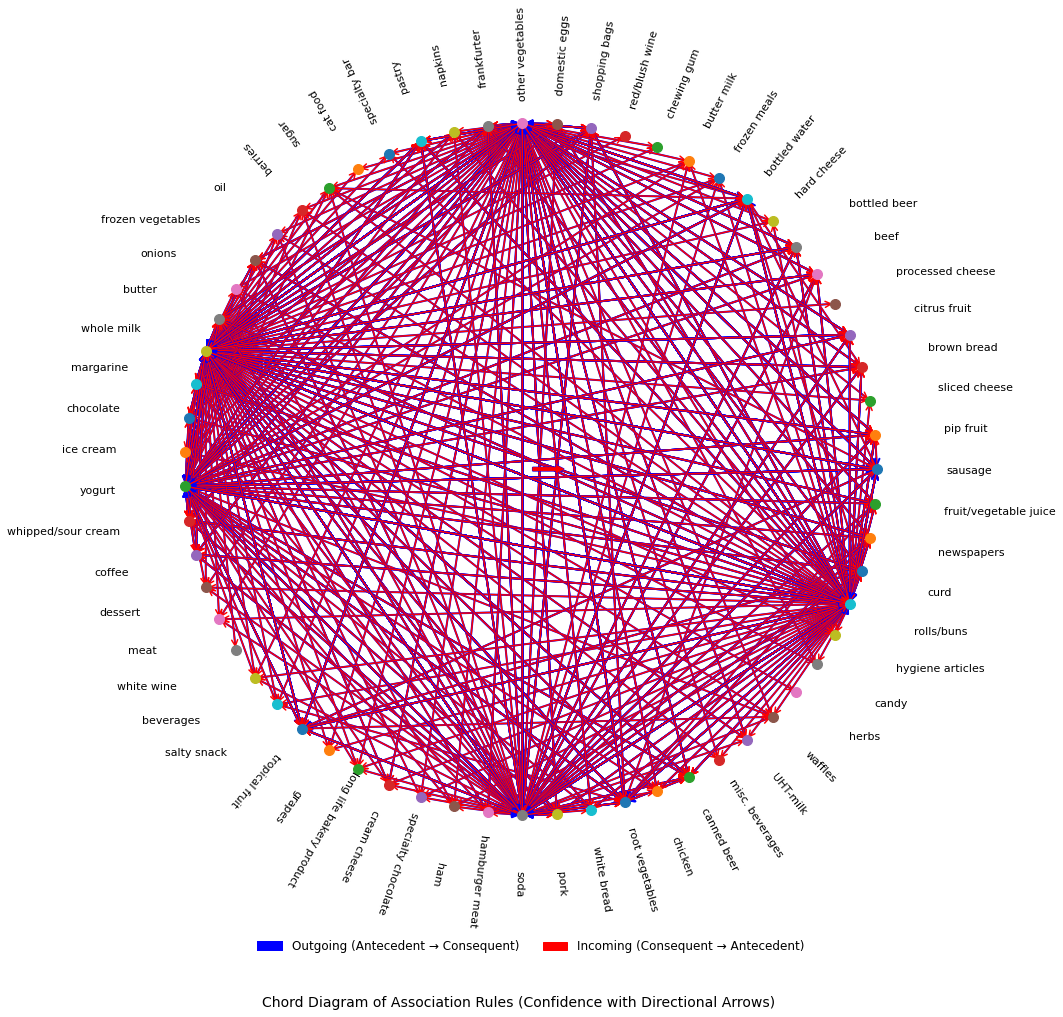

In [0]:
#visualize relationships between items, emphasizing the strength and directionality of rules

from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrowPatch
import numpy as np

# Create a circular layout
theta = np.linspace(0, 2 * np.pi, len(nodes), endpoint=False)
positions = {node: (np.cos(angle), np.sin(angle)) for node, angle in zip(nodes, theta)}

# Plot the chord diagram
fig, ax = plt.subplots(figsize=(14, 14))
ax.set_aspect("equal")
ax.set_axis_off()

# Draw nodes with rotated labels
for node, (x, y) in positions.items():
    angle = np.degrees(np.arctan2(y, x))  # Calculate the angle of the label

    # Adjust alignment and rotation based on node position
    if -45 <= angle <= 45:  # Right side of the circle
        ha = "left"
        rotation = 0
    elif 135 <= angle or angle <= -135:  # Left side of the circle
        ha = "right"
        rotation = 0
    else:  # Top and bottom of the circle
        ha = "center"
        rotation = angle

    ax.text(
        x * 1.2, y * 1.2, node,  # Adjust distance from the circle
        ha=ha, va="center_baseline", fontsize=11, rotation=rotation, rotation_mode="anchor"
    )
    ax.plot(x, y, 'o', markersize=10, label=node)

# Draw connections with clear arrow colors
for ant, cons, conf in connections:
    ant_pos = positions[ant]
    cons_pos = positions[cons]

    # Outgoing connection (antecedent → consequent)
    arrow = FancyArrowPatch(
        ant_pos, cons_pos,
        arrowstyle="->",
        color="blue",  # Outgoing arrows are blue
        mutation_scale=15,  # Size of the arrowhead
        lw=2  # Line width
    )
    ax.add_artist(arrow)

    # Optional: Add reverse (incoming) arrows in red for clarity
    reverse_arrow = FancyArrowPatch(
        cons_pos, ant_pos,
        arrowstyle="->",
        color="red",  # Incoming arrows are red
        mutation_scale=15,
        lw=1.5  # Slightly thinner for distinction
    )
    ax.add_artist(reverse_arrow)

# Add a legend
legend_labels = [
    FancyArrowPatch((0, 0), (0.1, 0), color="blue", mutation_scale=15, lw=2, label="Outgoing (Antecedent → Consequent)"),
    FancyArrowPatch((0, 0), (0.1, 0), color="red", mutation_scale=15, lw=1, label="Incoming (Consequent → Antecedent)")
]
for legend_arrow in legend_labels:
    ax.add_artist(legend_arrow)
plt.legend(
    handles=legend_labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False,
    fontsize=12
)

# Add a title below the graph
fig.suptitle(
    "Chord Diagram of Association Rules (Confidence with Directional Arrows)",
    fontsize=14,
    y=-0.02  # Position the title below the graph
)

plt.show()


**Identify Actionable Rules:** 

1, _High Confidence and Lift:_
- Rules have confidence between 60–65%, showing strong predictive reliability. Lift values range from 1.31 to 1.43, indicating associations are 31–43% stronger than random occurrences.

- Focus on Whole Milk: All rules predict whole milk as the consequent, highlighting its strong associations with various antecedents like yogurt, rolls/buns, and other vegetables.

- Support Levels:
Support ranges between 2–3% of transactions, indicating niche but significant patterns.

2, _Recommendations_
- Marketing and Promotions:  Customers who buy butter and yogurt together are likely to purchase whole milk as well. Offer discounts on whole milk for customers who buy ["butter", "yogurt"].

- Highlight whole milk in campaigns targeting buyers of antecedents like ["brown bread", "bottled water"].

- Store Layout and Product Placement: Place related products (e.g., yogurt, rolls/buns) near whole milk to encourage combined purchases.

- Provide free samples or create promotional bundles featuring both antecedents and consequents.

- Loyalty Programs and Upselling:

- Reward customers with loyalty points for purchasing combinations like ["bottled water", "rolls/buns"] → ["whole milk"].

- Recommend whole milk in online carts when antecedents like ["beef", "yogurt"] are added.


In [0]:
from pyspark.sql.functions import col
import pandas as pd

# Step 1: Filter association rules with high confidence and lift
filtered_rules = association_rules.filter((col("confidence") >= 0.6) & (col("lift") > 1.2))

# Step 2: Convert to Pandas for analysis
filtered_rules_pd = filtered_rules.toPandas()

# Step 3: Generate a sample insights table based on filtered rules
business_insights = filtered_rules_pd.head(10).copy()
business_insights["business_insight"] = [
    "Offer discounts on the consequent when the antecedent is purchased.",
    "Place antecedent and consequent near each other in-store.",
    "Recommend consequent to customers buying antecedent.",
    "Create a promotional bundle for antecedent and consequent.",
    "Use antecedent as a trigger for personalized recommendations.",
    "Introduce loyalty points for purchasing antecedent and consequent together.",
    "Highlight the consequent in marketing campaigns targeting antecedent buyers.",
    "Offer free samples of the consequent with antecedent purchases.",
    "Upsell consequent when antecedent is added to the cart.",
    "Train staff to recommend consequent when antecedent is purchased.",
]

# Step 4: Display insights in Databricks
display(pd.DataFrame(business_insights))


antecedent,consequent,confidence,lift,support,business_insight
"List(butter, yogurt)",List(whole milk),0.6,1.309518477043673,0.026936890713186248,Offer discounts on the consequent when the antecedent is purchased.
"List(yogurt, rolls/buns, other vegetables)",List(whole milk),0.6568627450980392,1.4336231693125179,0.03437660338635198,Place antecedent and consequent near each other in-store.
"List(beef, other vegetables)",List(whole milk),0.601010101010101,1.3117230536043525,0.030528476141611083,Recommend consequent to customers buying antecedent.
"List(bottled water, soda, other vegetables)",List(whole milk),0.6013986013986014,1.3125709676661523,0.022062596203181118,Create a promotional bundle for antecedent and consequent.
"List(bottled beer, pastry)",List(whole milk),0.6030534351145038,1.3161826932118341,0.020266803488968702,Use antecedent as a trigger for personalized recommendations.
"List(bottled water, rolls/buns, other vegetables)",List(whole milk),0.6293706293706294,1.373620780115741,0.023088763468445357,Introduce loyalty points for purchasing antecedent and consequent together.
"List(brown bread, bottled water)",List(whole milk),0.6148648648648649,1.3419615023758362,0.023345305284761416,Highlight the consequent in marketing campaigns targeting antecedent buyers.
"List(yogurt, soda, other vegetables)",List(whole milk),0.6488095238095238,1.4160467658507971,0.027963057978450487,Offer free samples of the consequent with antecedent purchases.
"List(beef, yogurt)",List(whole milk),0.6133333333333333,1.3386188876446434,0.023601847101077475,Upsell consequent when antecedent is added to the cart.
"List(shopping bags, root vegetables)",List(whole milk),0.6162162162162163,1.3449108683151236,0.029245767060030785,Train staff to recommend consequent when antecedent is purchased.


**Conclusion
**

The FPGrowth algorithm proved to be a valuable tool in analyzing the connections between product categories and exploring customer shopping behaviors. By uncovering frequent itemsets and generating association rules, the analysis provided key insights into how products are commonly purchased together.

The findings can help sellers, supermarkets, and grocery stores make data-driven decisions to optimize their operations and marketing strategies. Specifically, the analysis supports:

Promotion Campaigns:

- Design targeted promotions for itemsets that are frequently purchased together. For example, offering discounts or bundles on [Yogurt, Rolls/Buns] and [Butter, Whole Milk].

- Upselling Opportunities: Identify high-confidence association rules to recommend additional items at checkout. For instance, if a customer buys Bread, suggest Butter or Cheese.

- Improving Store Layout: Strategically place items with strong associations near each other to encourage combined purchases, such as grouping Dairy Products and Bakery Items.

- Customer Personalization:  Use antecedent products (e.g., Yogurt) as triggers to recommend consequents (e.g., Whole Milk) in e-commerce or loyalty programs.

By leveraging these insights, businesses can enhance customer satisfaction, increase revenue, and streamline their inventory management to meet demand effectively.